In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single 
# in this version, the centers given by the normal nll loss and the nll gaussian loss might be different

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

In [5]:
# random seeds
torch.manual_seed(1665)
np.random.seed(3266)

torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed_all(999)

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 500

samples_xs_1 = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
samples_labels_1 = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs_1, sep_plane)])

# gaussian target parameters
data_centers = -1*np.ones(num_dim)
sigma = 0.5

# second set
# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1500

samples_xs_2 = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
samples_labels_2 = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs_2, sep_plane)])


samples_xs = np.concatenate((samples_xs_1, samples_xs_2))
samples_labels = np.concatenate((samples_labels_1, samples_labels_2))

# shuffle in unison
permutation = np.random.permutation(len(samples_xs))
for old_index, new_index in enumerate(permutation):
    samples_xs[new_index] = samples_xs[old_index]
    samples_labels[new_index] = samples_labels[old_index]


<IPython.core.display.Javascript object>


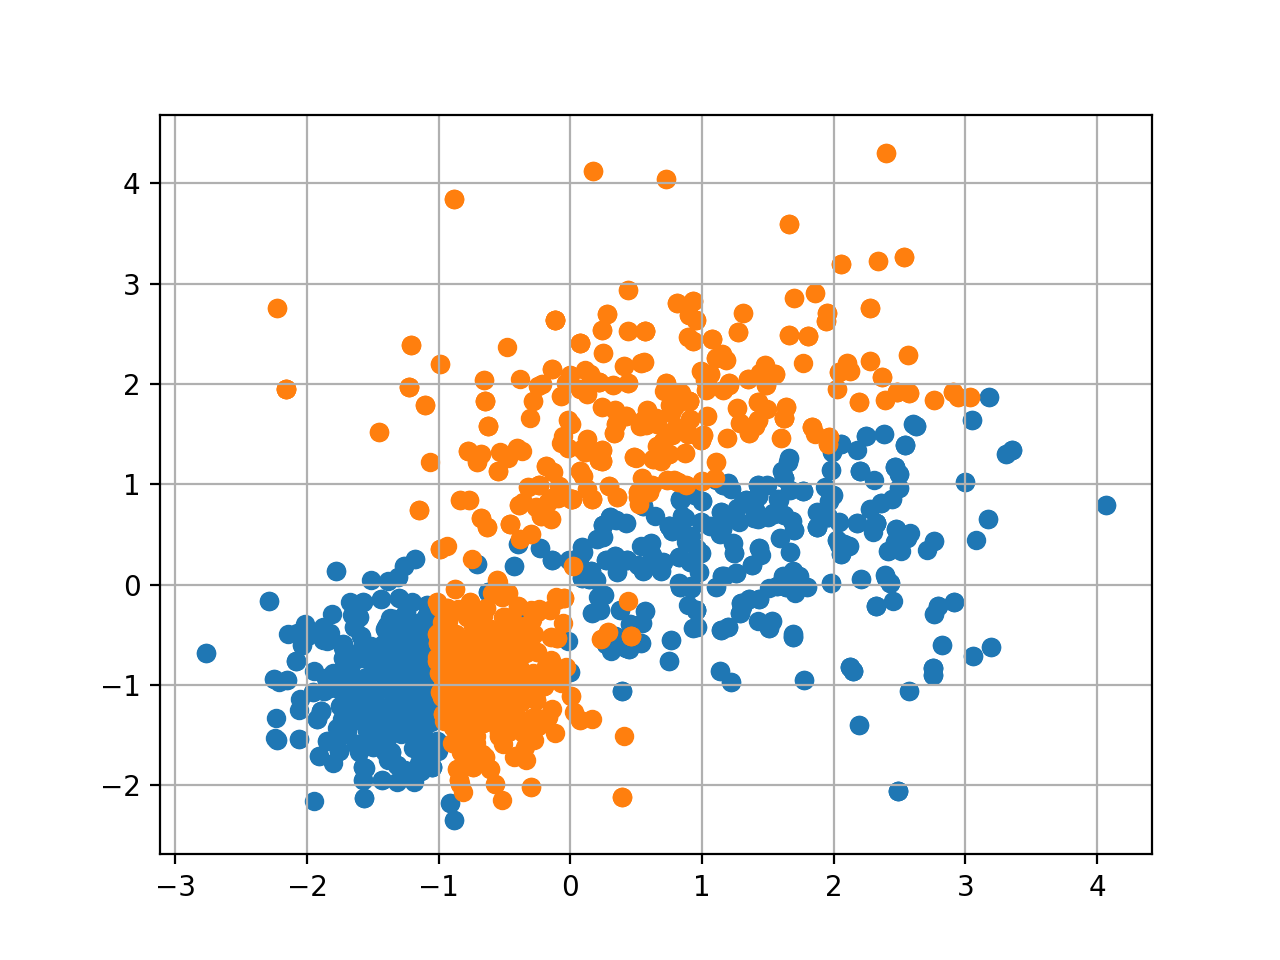

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==0]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==0]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)
# tensor_x = torch.stack([torch.Tensor(i) for i in zip(samples_x, samples_y)]) # transform to torch tensors
# tensor_y = torch.stack([torch.Tensor(i) for i in samples_labels])

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [10]:
# Define a Finite Gaussian Neural Network
class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = th.FGN_layer(2,2)
    def forward(self, x):
        x,l = self.l1(x)
        # clip res to +1 for mse loss only
#         x  = torch.clamp(x, min=-1.0, max=1.0)
        x = F.softmax(x, dim=-1)
        return x,l

In [11]:
# Initialize the network
model = FGNet().to(device)

In [12]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())
print(model.l1.pis.size())

# check weights before training
print("l1")
print(model.state_dict())

FGNet(
  (l1): FGN_layer()
)
[torch.Size([2, 2]), torch.Size([2, 2]), torch.Size([2]), torch.Size([2])]
Training? True
l1
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2])
l1
OrderedDict([('l1.weights', tensor([[ 1.1581, -0.2047],
        [-0.5675,  1.1696]])), ('l1.centers', tensor([[-0.0002, -0.0046],
        [ 0.0016,  0.0077]])), ('l1.sigs', tensor([2.0029, 2.0027])), ('l1.pis', tensor([0.5000, 0.5000]))])


In [13]:
# importances of the constraints
lmbda = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda)

# loss function
def loss_func(model, output, target):
    
    # split output into pred and likelihoods
    output, likelihood = output
    
#     # normal MSE loss
#     mse_loss = 1.0*F.nll_loss(output, target.long())
    # normal NLL loss
    loss = 1.0*F.nll_loss(output, target.long())
    # sum of sigma squares loss
    sig_loss = 0.0*lmbda*torch.mean(model.l1.sigs**2)

    # negative log likelihood over gaussian loss
#     nllg_loss = 100.0*lmbda*torch.sum(likelihood)
    nllg_loss = 0.0*torch.mean(likelihood)
    
    return loss + sig_loss + nllg_loss

0.000333333333333


In [14]:
# # number of correct pred function for mse loss
# def pred_func(output, target):
#     output,_ = output
#     pred = torch.Tensor.sign(output)
#     correct = pred.eq(target.view_as(pred)).sum().item()   
#     return correct

# number of correct pred function
def pred_func(output, target):
    output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [15]:
# model_optimizer
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, nesterov=True)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
# optimizer = optim.Adagrad(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()))


In [16]:
epochs = 10
train_res = th.train(model, device, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: -0.6117, Accuracy: 798/1200 (66%)
Test set - Average loss: -0.6332, Accuracy: 557/800 (70%)
Epoch 1 Train set - Average loss: -0.6504, Accuracy: 859/1200 (72%)
Test set - Average loss: -0.6688, Accuracy: 592/800 (74%)
Epoch 2 Train set - Average loss: -0.6753, Accuracy: 889/1200 (74%)
Test set - Average loss: -0.6966, Accuracy: 608/800 (76%)
Epoch 3 Train set - Average loss: -0.6918, Accuracy: 898/1200 (75%)
Test set - Average loss: -0.7110, Accuracy: 614/800 (77%)
Epoch 4 Train set - Average loss: -0.7013, Accuracy: 899/1200 (75%)
Test set - Average loss: -0.7197, Accuracy: 615/800 (77%)
Epoch 5 Train set - Average loss: -0.7075, Accuracy: 903/1200 (75%)
Test set - Average loss: -0.7258, Accuracy: 618/800 (77%)
Epoch 6 Train set - Average loss: -0.7121, Accuracy: 902/1200 (75%)
Test set - Average loss: -0.7304, Accuracy: 620/800 (78%)
Epoch 7 Train set - Average loss: -0.7157, Accuracy: 902/1200 (75%)
Test set - Average loss: -0.7342, Accuracy: 620/80

In [17]:
th.test(model, device, my_test_dataloader, loss_func, verbose=True, pred_func=pred_func)

Test set - Average loss: -0.7401, Accuracy: 620/800 (78%)


{'test_accuracy': 77.5, 'test_loss': -0.7400680302847923}

In [18]:
# print model state_dict post training
model.state_dict()

OrderedDict([('l1.weights', tensor([[ 3.3900, -2.8917],
                      [-0.2956,  4.1685]])),
             ('l1.centers', tensor([[0.9908, 0.9653],
                      [0.2473, 0.9927]])),
             ('l1.sigs', tensor([2.3310, 4.7108])),
             ('l1.pis', tensor([0.5000, 0.5000]))])

<IPython.core.display.Javascript object>


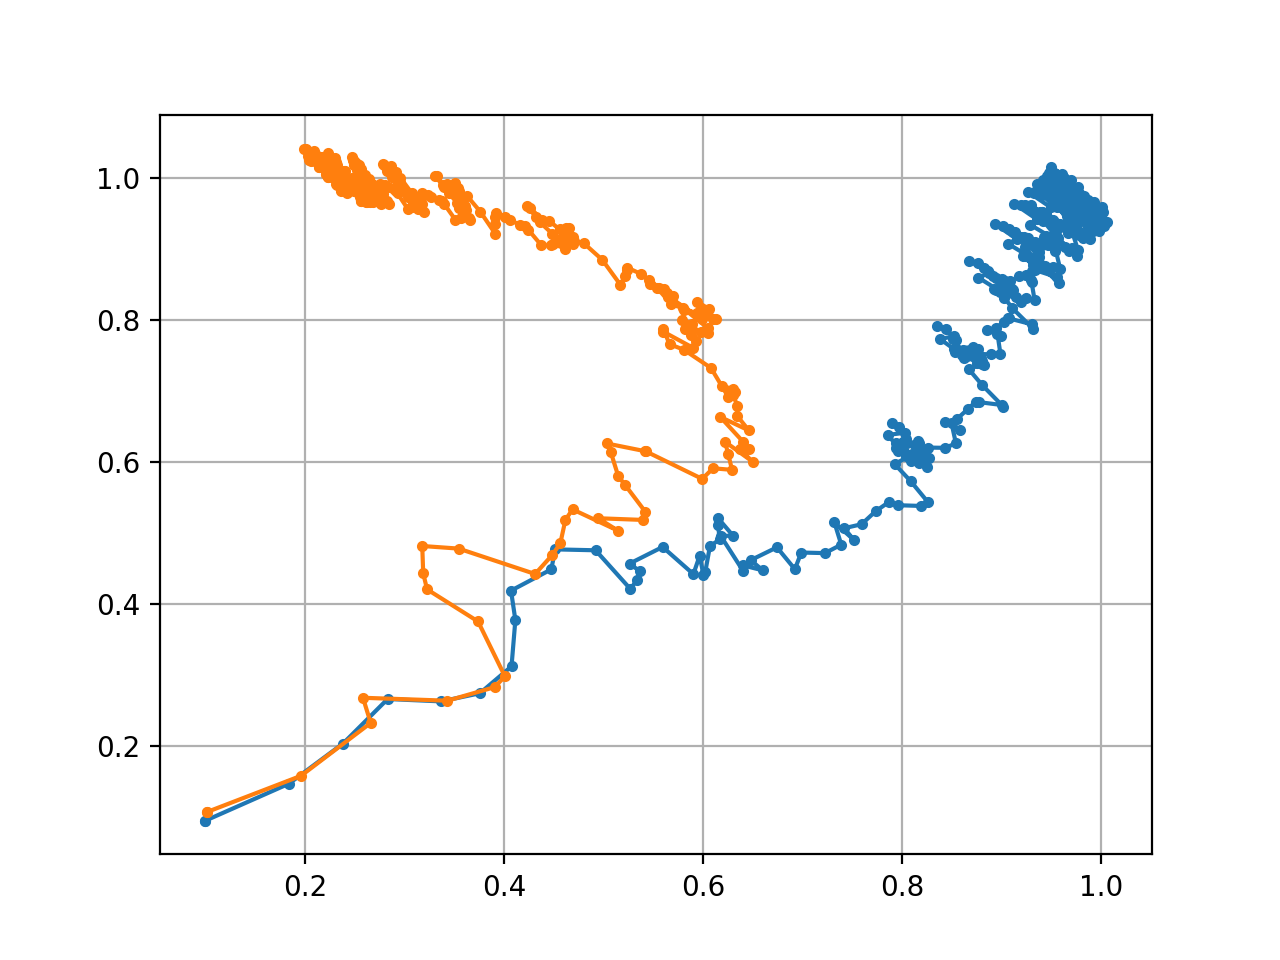

In [19]:
# compare center with targets
for ind in range(np.shape(train_res['histories']['l1.centers'])[1]):
    x, y = zip(*train_res['histories']['l1.centers'][:,ind,:])
    plt.plot(x,y, marker='.', linestyle='-')
# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


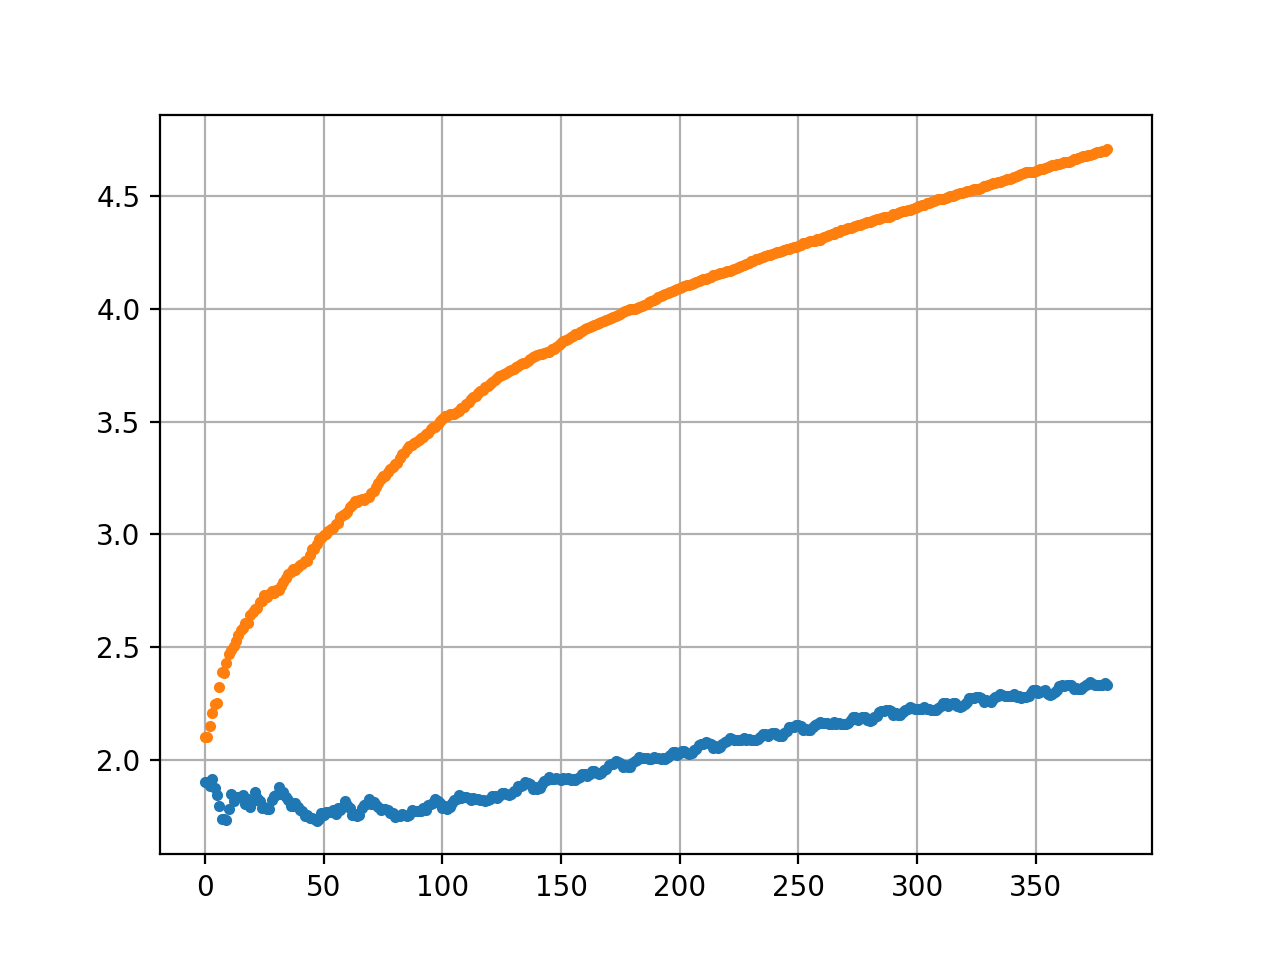

In [20]:
# plot sigma history
plt.plot(train_res['histories']['l1.sigs'][:,0], marker='.', linestyle=' ')
plt.plot(train_res['histories']['l1.sigs'][:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()

In [21]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

<IPython.core.display.Javascript object>


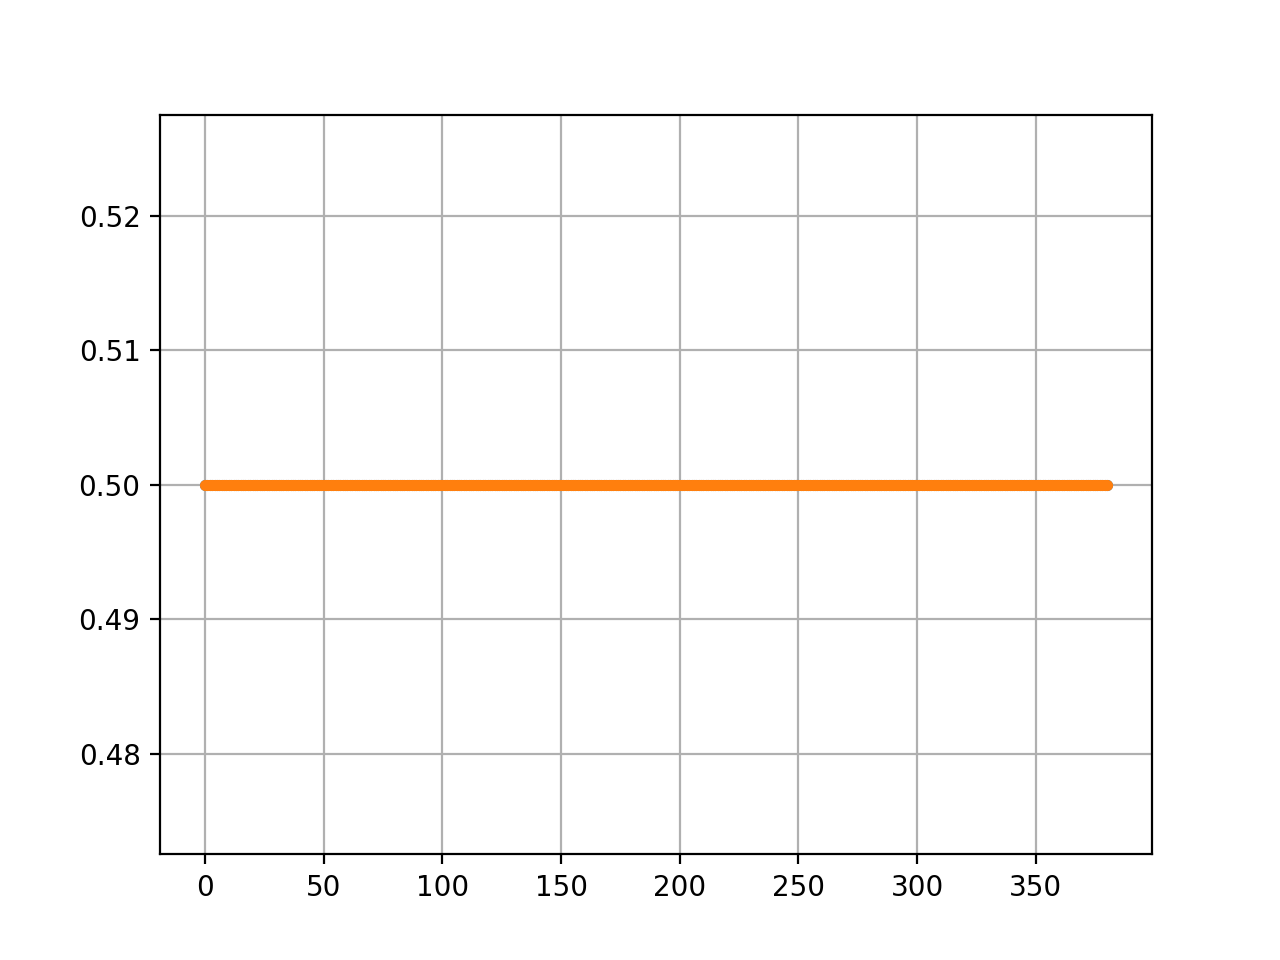

<IPython.core.display.Javascript object>


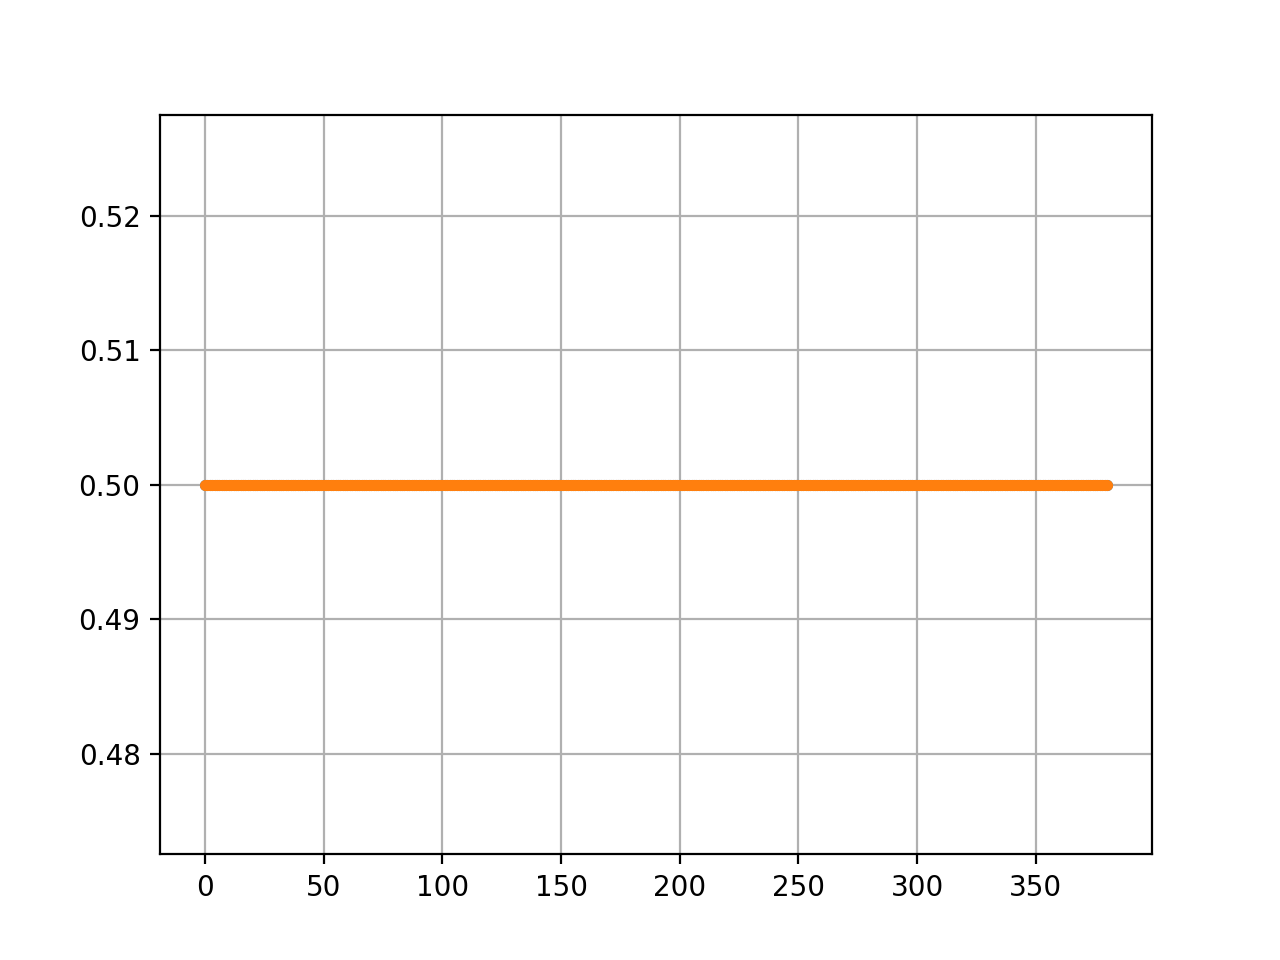

In [22]:
# plot softmax(PIs) history

# unormalized
plt.plot(train_res['histories']['l1.pis'][:,0], marker='.', linestyle=' ')
plt.plot(train_res['histories']['l1.pis'][:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()

#normalized 
normalized_PIs = np.array([softmax(x) for x in train_res['histories']['l1.pis']])
plt.plot(normalized_PIs[:,0], marker='.', linestyle=' ')
plt.plot(normalized_PIs[:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


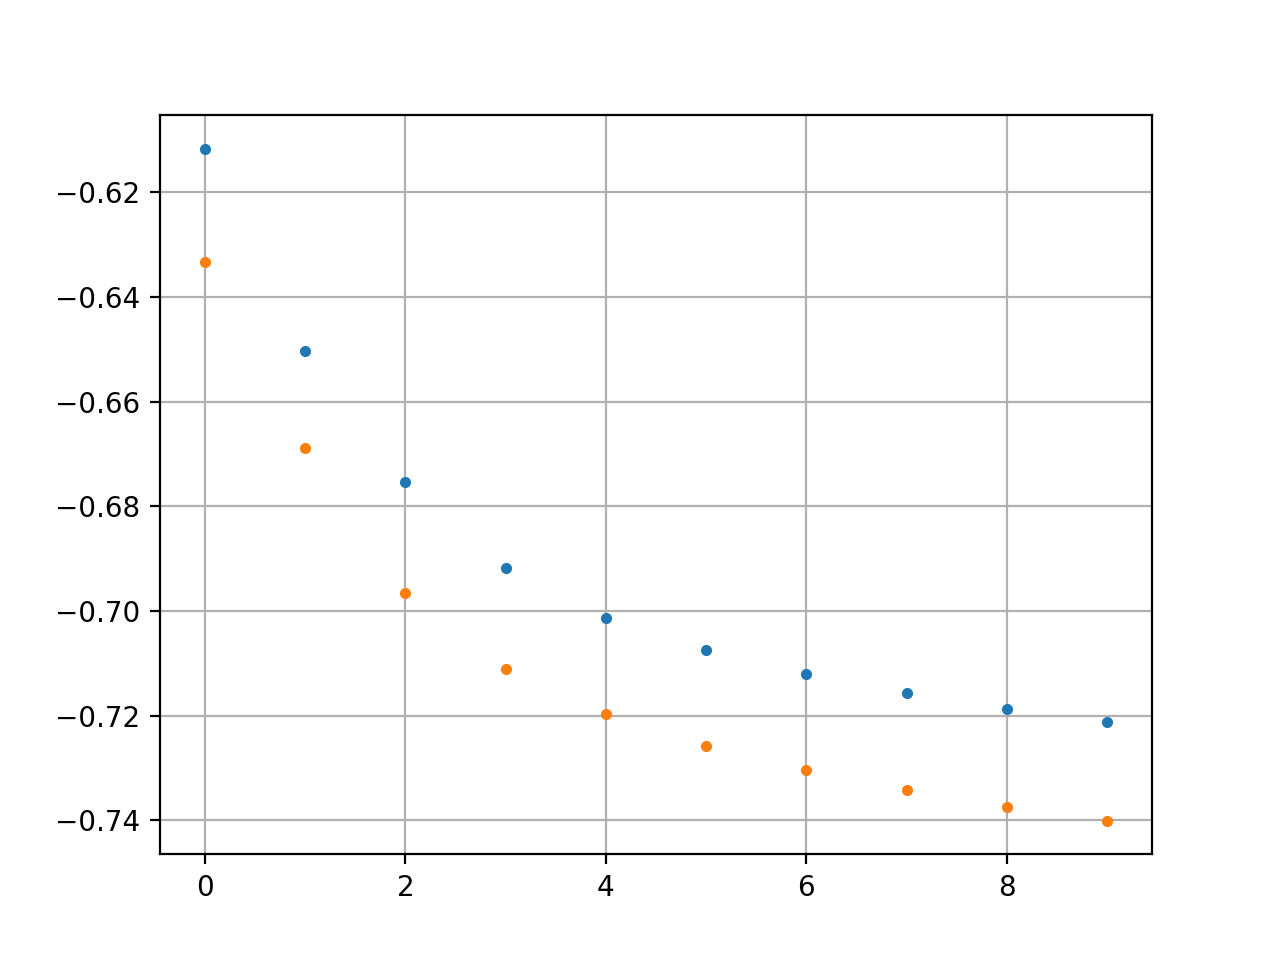

<IPython.core.display.Javascript object>


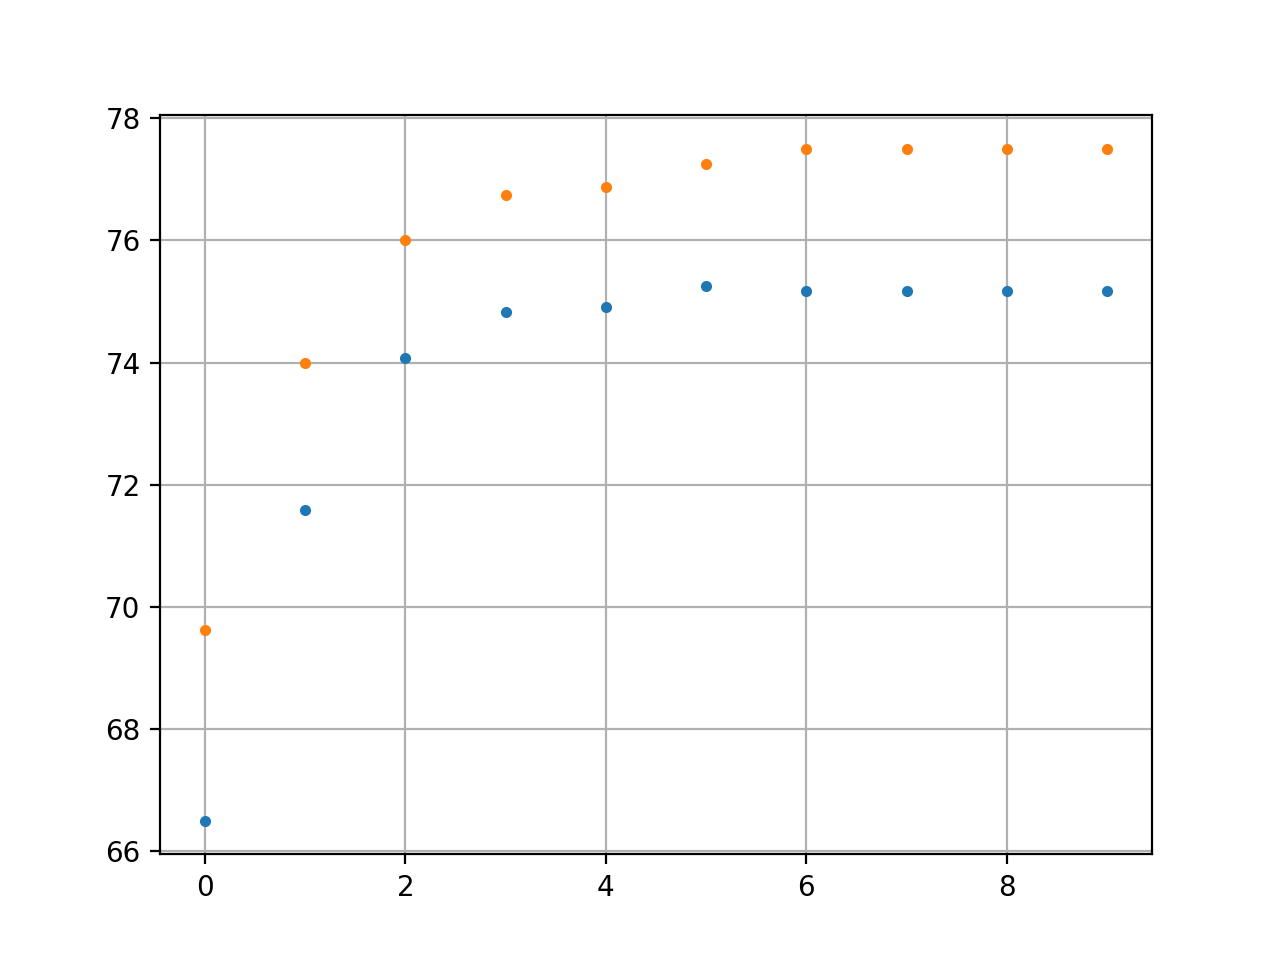

In [23]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()